# Parameter Histograms

This notebook loads a model and draws the histograms of the parameters tensors.

In [9]:
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
import scipy.stats as ss

# Relative import of code from distiller, w/o installing the package
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('../distiller'))
if module_path not in sys.path:
    sys.path.append(module_path)

import distiller
import models
from apputils import *

plt.style.use('seaborn') # pretty matplotlib plots

## Load your model

In [10]:
base_model = models.create_model(pretrained=False, dataset='cifar10', arch='resnet20_cifar', parallel=True)
load_checkpoint(base_model, '../resnet20_cifar_baseline/checkpoint.pth.tar')

element_pruned_model = models.create_model(pretrained=False, dataset='cifar10', arch='resnet20_cifar', parallel=True)
load_checkpoint(element_pruned_model, '../Element_Wise_Pruning/element_sparsity_74.94-Top1_90.02/checkpoint.pth.tar')

filter_pruned_model = models.create_model(pretrained=False, dataset='cifar10', arch='resnet20_cifar', parallel=True)
load_checkpoint(filter_pruned_model, '../Filter_Wise_Pruning/filter_MAC_41.58-Top1_90.4/checkpoint.pth.tar')

(DataParallel(
   (module): ResNetCifar(
     (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace)
     (layer1): Sequential(
       (0): BasicBlock(
         (conv1): Conv2d(16, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn1): BatchNorm2d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu1): ReLU()
         (conv2): Conv2d(7, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu2): ReLU()
       )
       (1): BasicBlock(
         (conv1): Conv2d(16, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn1): BatchNorm2d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu1): ReLU()
         (conv2): C

## Plot the distributions

We plot the distributions of the weights of each convolution layer, and we also plot the fitted Gaussian and Laplacian distributions.

In [113]:
def flatten(weights):
    weights = weights.view(weights.numel())
    weights = weights.data.cpu().numpy()
    return weights

def show_params(model):
    REMOVE_ZEROS = False
    nbins = 250
    for name, weights in model.named_parameters():
        if weights.dim() == 4:
            size_str = "x".join([str(s) for s in weights.size()])
            weights = flatten(weights)
        
            if REMOVE_ZEROS:
                # Optionally remove zeros (lots of zeros will dominate the histogram and the 
                # other data will be hard to see
                weights = weights[weights!=0]
        
            # Fit the data to the Normal distribution
            (mean_fitted, std_fitted) = ss.norm.fit(weights)
            x = np.linspace(min(weights), max(weights), nbins)
            weights_gauss_fitted = ss.norm.pdf(x, loc=mean_fitted, scale=std_fitted)

            # Fit the data to the Laplacian distribution
            (mean_fitted, std_fitted) = ss.laplace.fit(weights)
            weights_laplace_fitted = ss.laplace.pdf(x, loc=mean_fitted, scale=std_fitted)

            plt.figure(figsize=(5, 4))
            text = '$\mu$ = %2.4f\n$\sigma$ = %2.4f' %(mean_fitted, std_fitted)
            
            n, bins, patches = plt.hist(weights, histtype='stepfilled', 
                                    cumulative=False, bins=nbins, normed=1)
            #plt.plot(x, weights_gauss_fitted, label='gauss')
            #plt.plot(x, weights_laplace_fitted, label='laplace')
            left, right = plt.xlim()
            down, top = plt.ylim()
            plt.text(left, top, text, ha='left', va='top')
            plt.title(name + " - " +size_str)
            # plt.legend()
            plt.show()

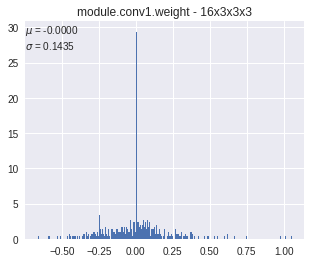

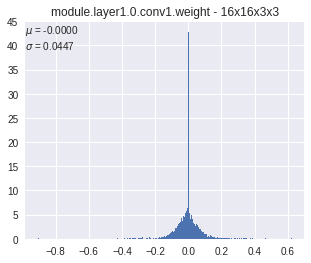

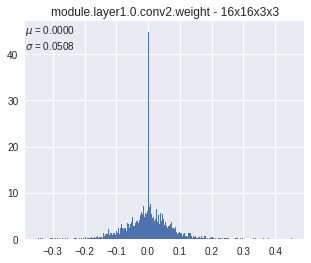

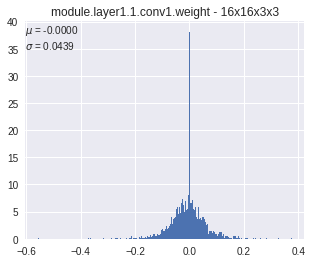

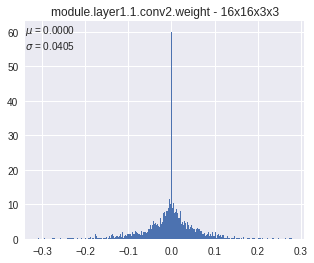

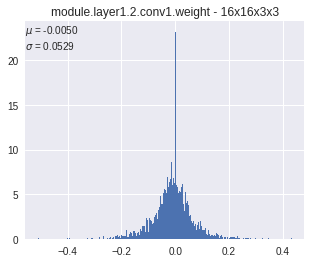

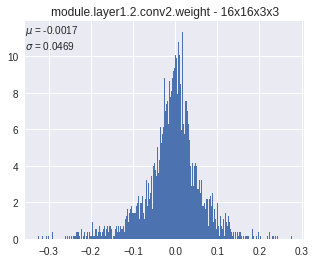

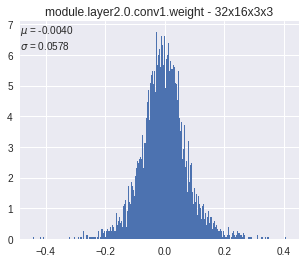

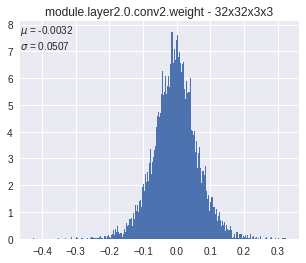

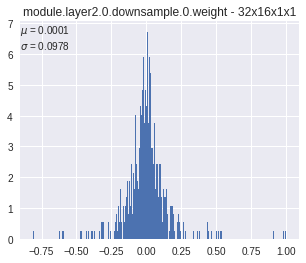

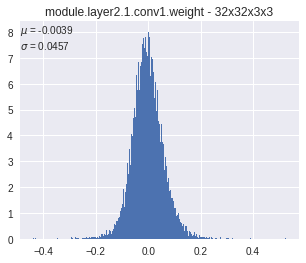

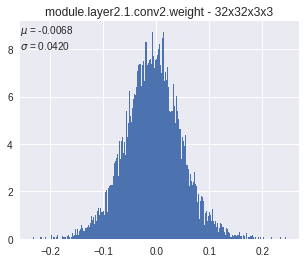

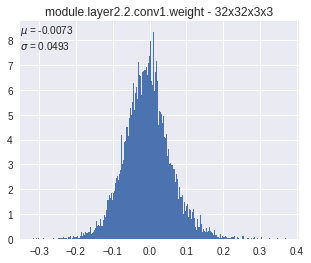

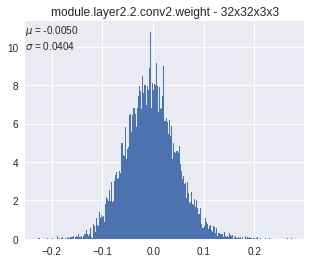

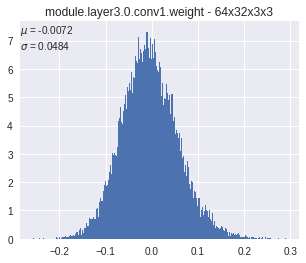

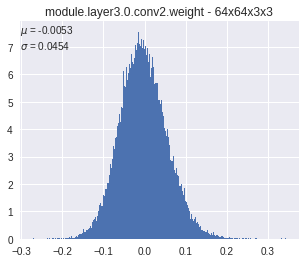

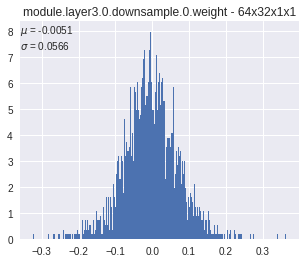

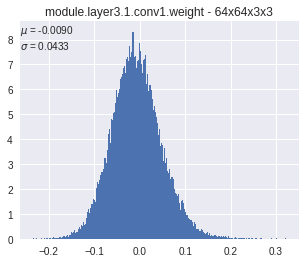

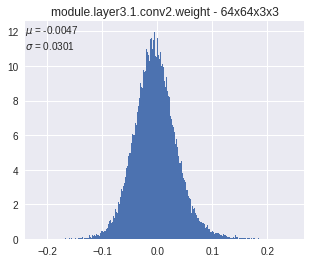

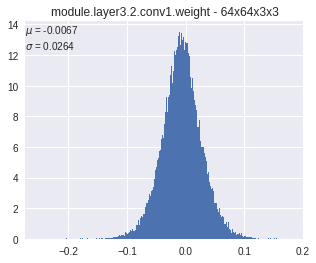

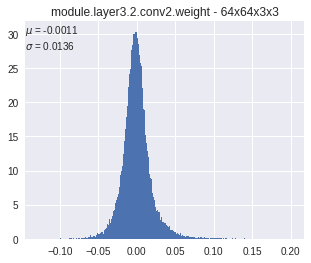

In [114]:
show_params(base_model)

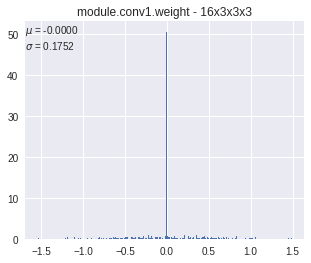

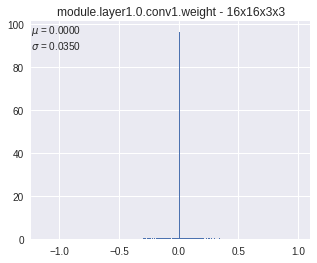

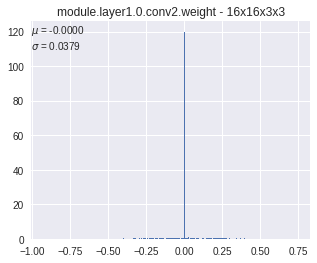

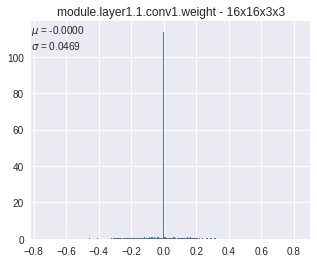

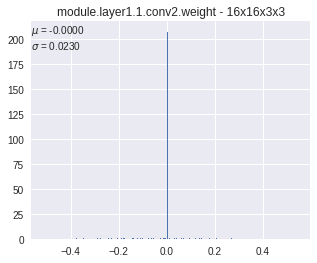

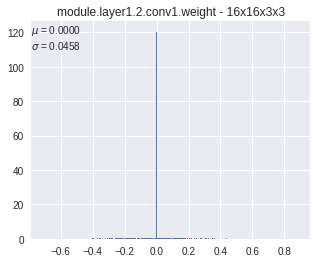

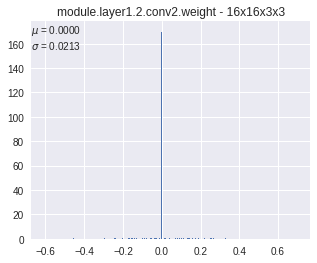

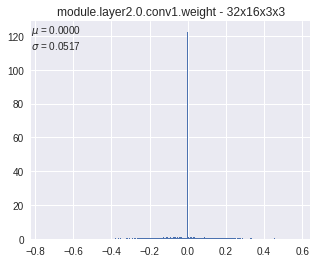

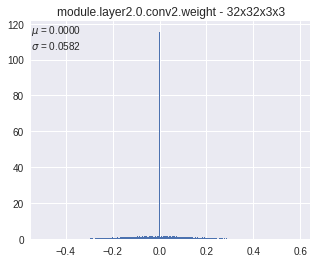

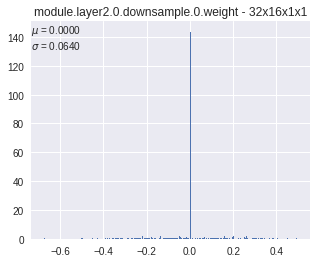

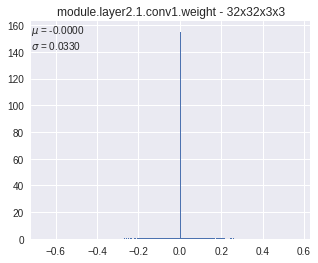

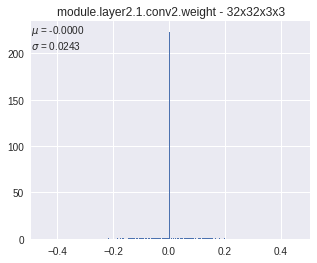

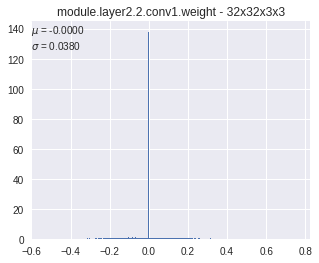

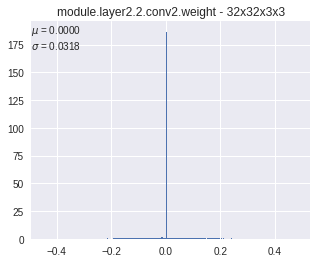

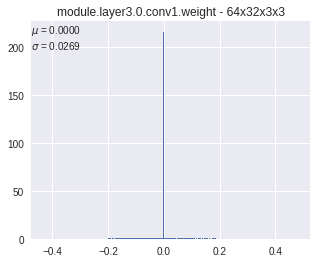

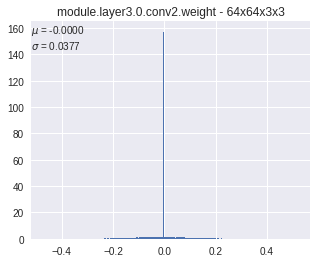

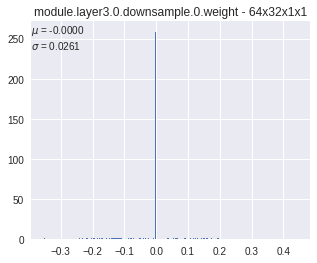

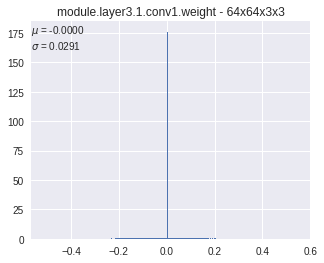

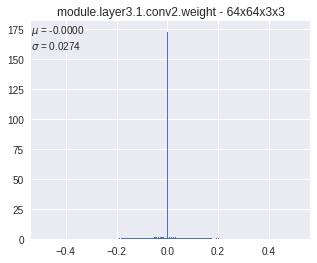

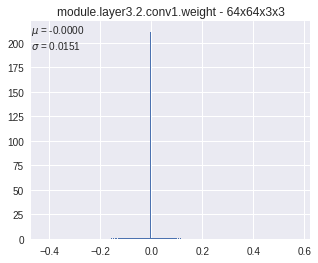

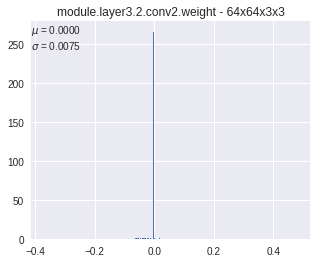

In [115]:
show_params(element_pruned_model)

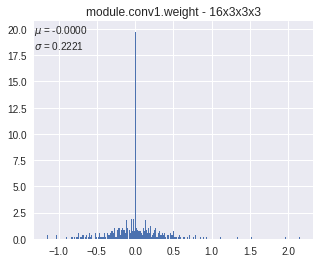

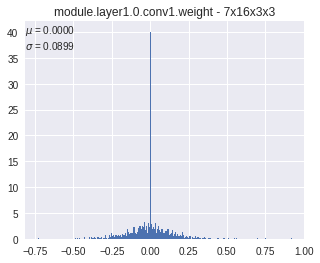

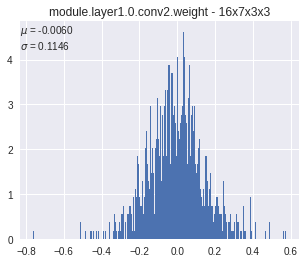

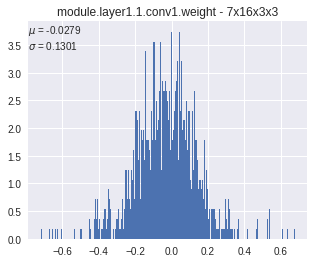

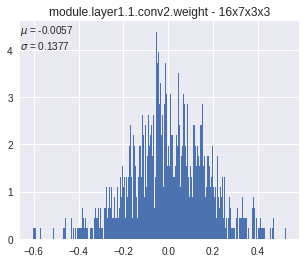

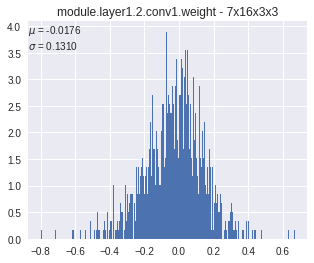

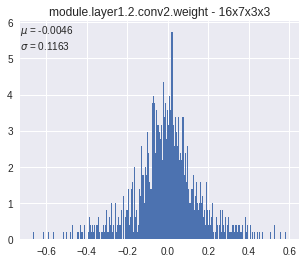

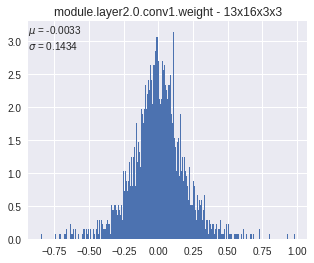

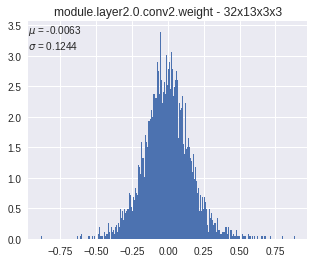

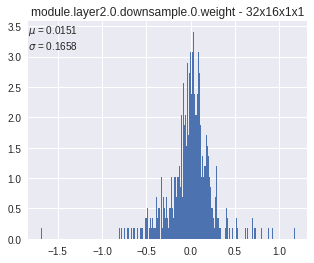

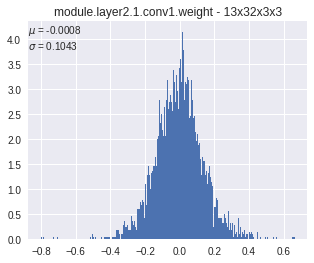

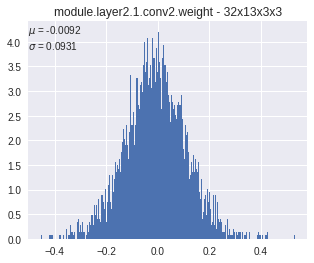

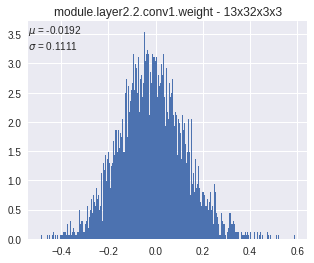

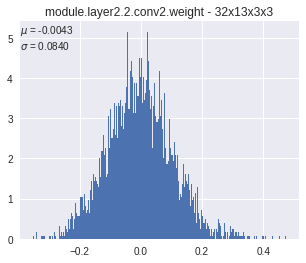

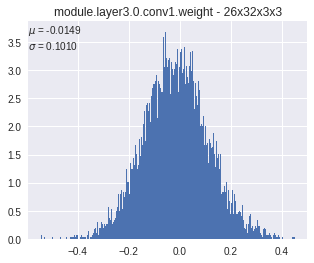

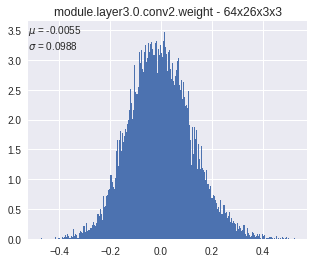

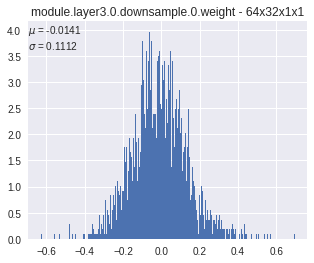

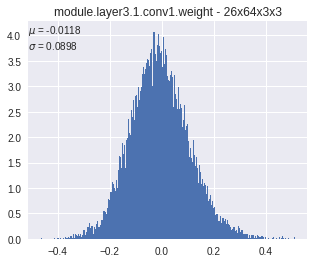

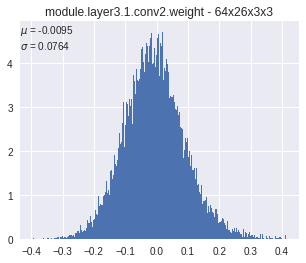

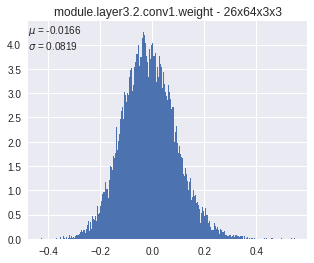

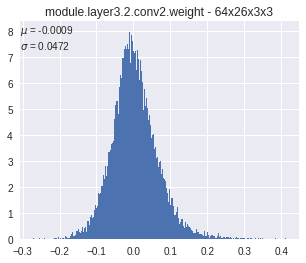

In [116]:
show_params(filter_pruned_model)